In [1]:
import os
import pathlib
import random
import shutil
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary

import torchvision
from torchvision import transforms, datasets

from torchmetrics import ConfusionMatrix
from torchmetrics.classification import MulticlassAccuracy
from mlxtend.plotting import plot_confusion_matrix

from tqdm.auto import tqdm

# Note: this notebook requires torch >= 1.10.0
torch.__version__

c:\Users\arasyidi\AppData\Local\mambaforge\envs\torch_gpu\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


'2.0.1'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Preparation

1. Make training, validation and testing folder
1. Move 70% of the data to training folder
1. Move 20% of the data to validation folder
1. Move 10% of the data to testing folder

Folder structure after this process

```
data
    └─── EuroSAT_MS
        ├─── train
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_1.jpg
        |   |   ├─── AnnualCrop_2.jpg
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_1.jpg
        |   |   ├─── Forest_2.jpg
        |   |   └─── ...
        ├─── valid
        |   └─── AnnualCrop
        |   |   ├─── AnnualCrop_3.jpg
        |   |   ├─── AnnualCrop_4.jpg
        |   |   └─── ...
        |   ├─── Forest
        |   |   ├─── Forest_3.jpg
        |   |   ├─── Forest_4.jpg
        |   |   └─── ...
        └─── test
            └─── AnnualCrop
            |   ├─── AnnualCrop_1.jpg
            |   ├─── AnnualCrop_2.jpg
            |   └─── ...
            └─── Forest
                ├─── Forest_1.jpg
                ├─── Forest_2.jpg
                └─── ...
```

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 64

## Make a function to reorganize the folder

In [4]:
def reorganize_folder_structure(
        source_folder, 
        destination_folder, 
        train_ratio, 
        valid_ratio,
        random_seed = RANDOM_SEED
        ):
    # Create the destination folders
    train_folder = destination_folder / "train"
    valid_folder = destination_folder / "valid"
    test_folder = destination_folder / "test"
    os.makedirs(train_folder, exist_ok=False)
    os.makedirs(valid_folder, exist_ok=False)
    os.makedirs(test_folder, exist_ok=False)

    # Loop through the source folder
    for class_folder in os.listdir(source_folder):
        if os.path.isdir(os.path.join(source_folder, class_folder)):
            # Create the destination class folders
            train_class_folder = train_folder / class_folder
            valid_class_folder = valid_folder / class_folder
            test_class_folder = test_folder / class_folder
            os.makedirs(train_class_folder, exist_ok=False)
            os.makedirs(valid_class_folder, exist_ok=False)
            os.makedirs(test_class_folder, exist_ok=False)

            # Get the list of image files in the class folder
            image_files = [
                f for f in os.listdir(os.path.join(source_folder, class_folder))
                if os.path.isfile(os.path.join(source_folder, class_folder, f))
            ]

            # Shuffle the image files
            random.Random(random_seed).shuffle(image_files)

            # Split the files into train, valid, and test sets
            train_count = int(train_ratio * len(image_files))
            valid_count = int(valid_ratio * len(image_files))
            train_files = image_files[:train_count]
            valid_files = image_files[train_count:train_count+valid_count]
            test_files = image_files[train_count+valid_count:]

            # Move the files to the corresponding folders
            for file in train_files:
                src_path = os.path.join(source_folder, class_folder, file)
                dst_path = os.path.join(train_class_folder, file)
                shutil.copy(src_path, dst_path)

            for file in valid_files:
                src_path = os.path.join(source_folder, class_folder, file)
                dst_path = os.path.join(valid_class_folder, file)
                shutil.copy(src_path, dst_path)

            for file in test_files:
                src_path = os.path.join(source_folder, class_folder, file)
                dst_path = os.path.join(test_class_folder, file)
                shutil.copy(src_path, dst_path)

## Initiate folder variables

In [5]:
# Prepare the folder and its name
root_dir = os.getcwd()
root_dir = pathlib.Path(root_dir)

data_path = root_dir / "data"
original_eurosat_path = data_path / "EuroSAT"
new_eurosat_path = data_path / "EuroSAT_reorganized"

# Setup train, valid, and testing paths
train_path = new_eurosat_path / "train"
valid_path = new_eurosat_path / "valid"
test_path = new_eurosat_path / "test"

# put all the class names inside a list
class_name = os.listdir(original_eurosat_path)
print(class_name, len(class_name))

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'] 10


In [6]:
# # Setup training data
# train_data = datasets.FashionMNIST(
#     root="data", # where to download data to?
#     train=True, # get training data
#     download=True, # download data if it doesn't exist on disk
#     transform=transforms.ToTensor(), # images come as PIL format, we want to turn into Torch tensors
#     target_transform=None # you can transform labels as well
# )

In [7]:
# Specify the source and destination folders
source_folder = original_eurosat_path
destination_folder = new_eurosat_path

# Specify the train, valid, and test ratios
train_ratio = 0.6
valid_ratio = 0.2

# Reorganize the folder structure
try:
    reorganize_folder_structure(
        source_folder, 
        destination_folder, 
        train_ratio, 
        valid_ratio
        )
except:
    print("Folders already exist")

Folders already exist


## Check the result

PermanentCrop


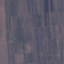

In [8]:
temp_class = random.choice(class_name)
index = random.randint(0,600)
print(temp_class)
Image.open(train_path / temp_class / os.listdir(train_path / temp_class)[index])

# Turn the data into a DataLoader

In [9]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.ImageFolder(root=test_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT = train_dataset[0][0].shape[0], train_dataset[0][0].shape[1], train_dataset[0][0].shape[2]
print(IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT)

3 64 64


(-0.5, 63.5, 63.5, -0.5)

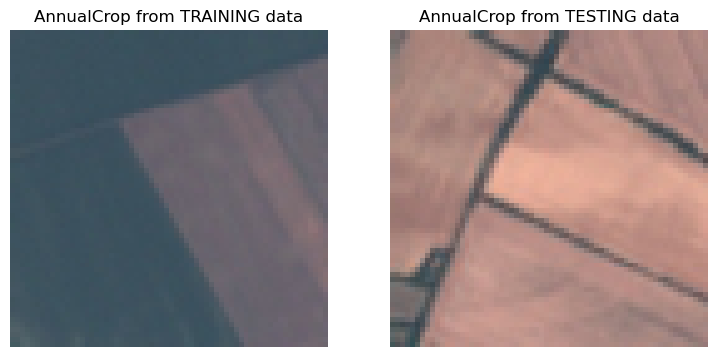

In [11]:
fig = plt.figure(figsize=(9, 9))

img, label = train_dataset[index]
fig.add_subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from TRAINING data")
plt.axis(False)

img, label = test_dataset[index]
fig.add_subplot(1, 2, 2)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"{class_name[label]} from TESTING data")
plt.axis(False)

# Training

## Baseline

## EfficientNet_B0

In [12]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights_enb0 = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model_enb0 = torchvision.models.efficientnet_b0(weights=weights_enb0).to(device)

In [13]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_enb0,
        input_size=(BATCH_SIZE, IMG_CHANNEL, IMG_WIDTH, IMG_HEIGHT), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 64, 64]      [64, 1000]           --                   True
├─Sequential (features)                                      [64, 3, 64, 64]      [64, 1280, 2, 2]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 64, 64]      [64, 32, 32, 32]     --                   True
│    │    └─Conv2d (0)                                       [64, 3, 64, 64]      [64, 32, 32, 32]     864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 32, 32]     [64, 32, 32, 32]     64                   True
│    │    └─SiLU (2)                                         [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
│    └─Sequential (1)                                        [64, 32, 32, 32]     [64, 16, 32,

In [14]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_enb0.features.parameters():
    param.requires_grad = False

In [15]:
# Set the manual seeds
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_name)

# Recreate the classifier layer and seed it to the target device
model_enb0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_enb0.parameters(), lr=0.001)

In [17]:
# epoch = 2
# metric = MulticlassAccuracy(num_classes=len(class_name)).to(device)

# for i in range(epoch):
#     train_loss = 0
#     train_acc = []
#     for batch, (X, y) in enumerate(train_loader):
#         # Send data to GPU
#         X, y = X.to(device), y.to(device)

#         # 1. Forward pass
#         y_pred = model_enb0(X)

#         # 2. Calculate loss
#         loss = loss_fn(y_pred, y)
#         train_loss += loss

#         # 3. Optimizer zero grad
#         optimizer.zero_grad()

#         # 4. Loss backward
#         loss.backward()

#         # 5. Optimizer step
#         optimizer.step()

#         train_acc.append(metric(y_pred, y).item()*100)

#         # print(train_loss, train_acc)

#     # Calculate loss and accuracy per epoch and print out what's happening
#     train_loss /= len(train_loader)
#     train_acc = sum(train_acc) / len(train_acc)

#     print(f"Test loss: {train_loss:.5f} | Test accuracy: {train_acc:.2f}%\n")

In [48]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [49]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [50]:
# Setup training and save the results
EPOCH = 5
# metric = MulticlassAccuracy(num_classes=len(class_name)).to(device)

results = train(
    model=model_enb0,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCH,
    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5592 | train_acc: 0.8086 | test_loss: 0.5682 | test_acc: 0.8293
Epoch: 2 | train_loss: 0.5775 | train_acc: 0.8075 | test_loss: 0.5993 | test_acc: 0.8269
Epoch: 3 | train_loss: 0.5624 | train_acc: 0.8135 | test_loss: 1.4518 | test_acc: 0.8225
Epoch: 4 | train_loss: 0.5822 | train_acc: 0.8093 | test_loss: 0.6471 | test_acc: 0.8252
Epoch: 5 | train_loss: 0.5577 | train_acc: 0.8119 | test_loss: 0.5595 | test_acc: 0.8275


In [21]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

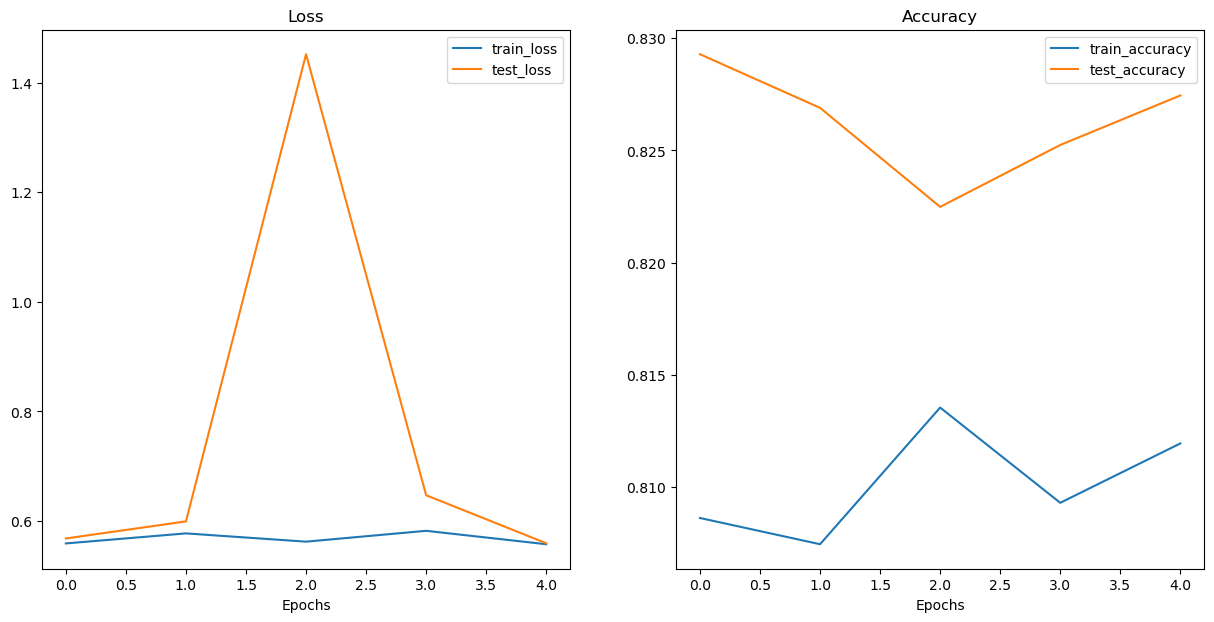

In [51]:
plot_loss_curves(results)

In [23]:
# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device
                        ):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    # plt.figure()
    plt.imshow(img)
    plt.title(
        f"""
        Pred: {class_names[target_image_pred_label]} 
        Prob: {target_image_pred_probs.max():.3f}
        """
    )
    plt.axis(False);

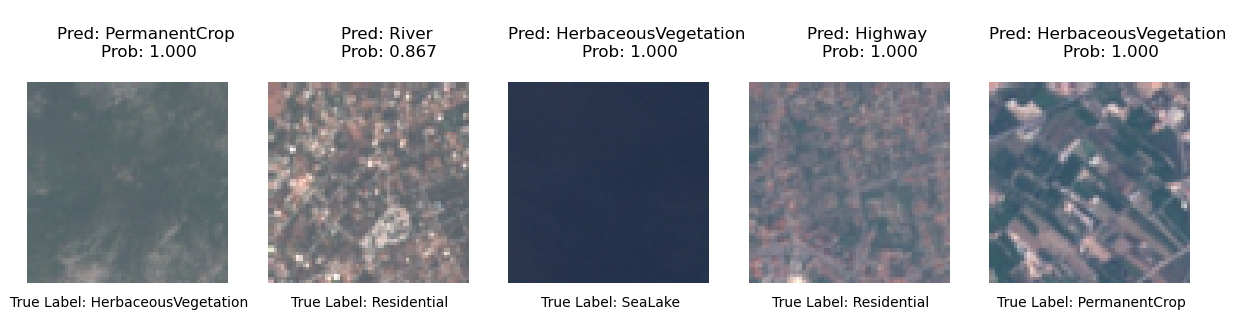

In [52]:
num_images_to_plot = 5
test_image_path_list = list(pathlib.Path(test_path).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
fig = plt.figure(figsize=(15,5))
for position, image_path in enumerate(test_image_path_sample):
    ax = fig.add_subplot(1, num_images_to_plot, position+1)
    pred_and_plot_image(model=model_enb0, 
                        image_path=image_path,
                        class_names=class_name,
                        transform=weights_enb0.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(IMG_WIDTH, IMG_HEIGHT)
                        )
    ax.text(32,70, f"True Label: {image_path.parent.name}", ha='center', va='center')

In [53]:
# 1. Make predictions with trained model
y_preds = []
model_enb0.to(device).eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_enb0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/85 [00:00<?, ?it/s]

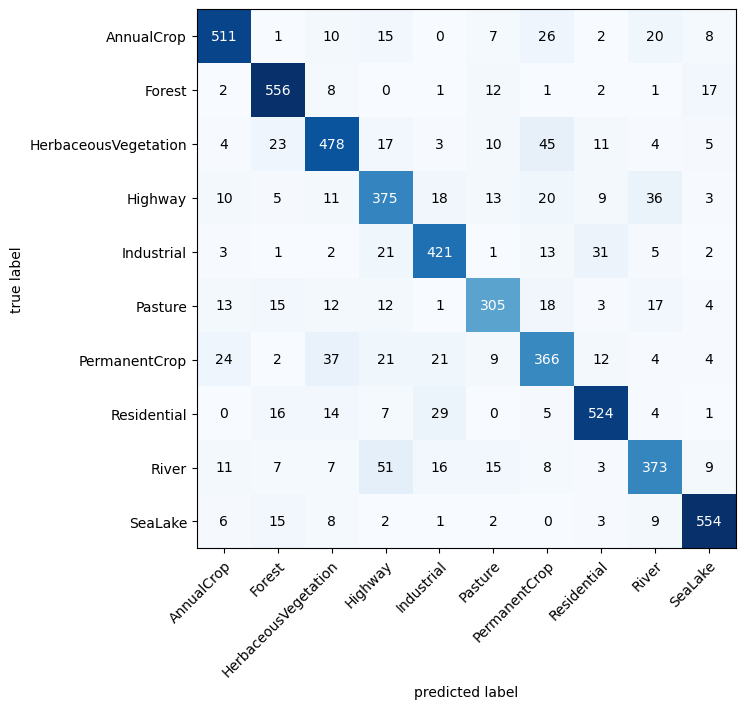

In [54]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_name), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_dataset.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_name, # turn the row and column labels into class names
    figsize=(10, 7)
);

Pasture


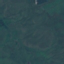

In [72]:
temp_class = random.choice(class_name)
index = random.randint(0,600)
print(temp_class)
Image.open(train_path / temp_class / os.listdir(train_path / temp_class)[index])

In [73]:
image_path = train_path / temp_class / os.listdir(train_path / temp_class)[index]
img = Image.open(image_path)

In [74]:
image_transform = transform

In [75]:
transformed_image = image_transform(img).unsqueeze(dim=0)

In [76]:
target_image_pred = model_enb0(transformed_image.to(device))

In [77]:
target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
target_image_pred_label

tensor([5], device='cuda:0')

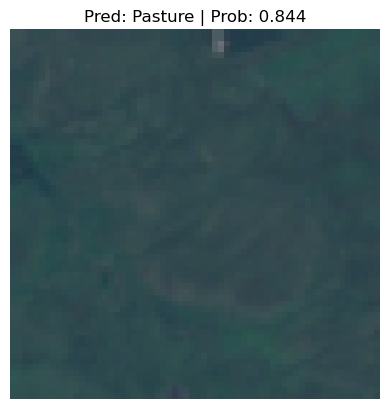

In [78]:
plt.figure()
plt.imshow(img)
plt.title(f"Pred: {class_name[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
plt.axis(False);

In [ ]:
with torch.inference_mode():
  y_logit = model_enb0(X)
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_enb0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)